In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import os
import time
import warnings

import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import optuna
from tqdm.notebook import tqdm
import lightgbm as lgb
import xgboost as xgb

import sklearn
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)

In [ ]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
plt.style.use('dark_background')

In [ ]:
class CFG:
    NUM_WORKERS = os.cpu_count()
    SEED = 24
    TARGET = 'machine_status'
    TARGET_ENCODED = 'target'
    NUM_FOLDS = 5

    # Define data directory paths
    DATASET_PATH = '/content/drive/MyDrive/Data Visualisation Datasets/'

    # Define .csv paths
    DATA_CSV = '/content/drive/MyDrive/Data Visualisation Datasets/sensor.csv'

In [ ]:
def reduce_memory(df:pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    original_memory = (df.memory_usage().sum()) / (1024 ** 2)

    for column in df.columns:
        column_dtype = df[column].dtype

        if (column_dtype != object) and (column_dtype != str):
            if (str(column_dtype) + '______')[:3] == 'int':
                df[column] = df[column].astype(np.int32)
            if (str(column_dtype) + '______')[:5] == 'float':
                df[column] = df[column].astype(np.float32)

    if verbose:
        print('-----------------------------------------------------')
        print(f'Memory usage of dataframe:\t\t{original_memory:.2f} MB')

        altered_memory = df.memory_usage().sum() / 1024**2
        print(f'Memory usage after dtype conversion:\t{altered_memory:.2f} MB')

        memory_variance = 100 * (original_memory - altered_memory) / original_memory
        print(f'Memory consumption decreased by:\t{memory_variance:.2f}%')
        print('-----------------------------------------------------')

    return df

In [ ]:
# Load & view the dataset
print('Loading Data...')
data_df = reduce_memory(pd.read_csv(CFG.DATA_CSV))

print('\nView first 5 rows in dataset...\n')
data_df.head(5)

Loading Data...
-----------------------------------------------------
Memory usage of dataframe:		92.45 MB
Memory usage after dtype conversion:	47.91 MB
Memory consumption decreased by:	48.18%
-----------------------------------------------------

View first 5 rows in dataset...



Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394  47.092010    53.2118   
1           1  2018-04-01 00:01:00   2.465394  47.092010    53.2118   
2           2  2018-04-01 00:02:00   2.444734  47.352428    53.2118   
3           3  2018-04-01 00:03:00   2.460474  47.092010    53.1684   
4           4  2018-04-01 00:04:00   2.445718  47.135410    53.2118   

   sensor_03   sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760  634.375000  76.459747   13.41146  16.131359  ...  41.927078   
1  46.310760  634.375000  76.459747   13.41146  16.131359  ...  41.927078   
2  46.397572  638.888916  73.545982   13.32465  16.037331  ...  41.666660   
3  46.397568  628.125000  76.988983   13.31742  16.247110  ...  40.885410   
4  46.397568  636.458313  76.588966   13.35359  16.210939  ...  41.406250   

   sensor_44  sensor_45  sensor_46  sensor_47   sensor_48  sensor_49  \
0  39.641201  65.682869  50.925930  38.194439  157.986099  67.708344   
1  39.641201  65.682869  50.925930  38.194439  157.986099  67.708344   
2  39.351852  65.393517  51.215279  38.194443  155.960602  67.129631   
3  39.062500  64.814812  51.215279  38.194439  155.960602  66.840279   
4  38.773151  65.104156  51.793980  38.773151  158.275497  66.550926   

    sensor_50   sensor_51  machine_status  
0  243.055603  201.388901          NORMAL  
1  243.055603  201.388901          NORMAL  
2  241.319397  203.703705          NORMAL  
3  240.451401  203.125000          NORMAL  
4  242.187500  201.388901          NORMAL  

[5 rows x 55 columns]

In [ ]:
data_df = data_df.iloc[:, 1:]
data_df.head(3)

timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
0  2018-04-01 00:00:00   2.465394  47.092010    53.2118  46.310760   
1  2018-04-01 00:01:00   2.465394  47.092010    53.2118  46.310760   
2  2018-04-01 00:02:00   2.444734  47.352428    53.2118  46.397572   

    sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_43  \
0  634.375000  76.459747   13.41146  16.131359   15.56713  ...  41.927078   
1  634.375000  76.459747   13.41146  16.131359   15.56713  ...  41.927078   
2  638.888916  73.545982   13.32465  16.037331   15.61777  ...  41.666660   

   sensor_44  sensor_45  sensor_46  sensor_47   sensor_48  sensor_49  \
0  39.641201  65.682869  50.925930  38.194439  157.986099  67.708344   
1  39.641201  65.682869  50.925930  38.194439  157.986099  67.708344   
2  39.351852  65.393517  51.215279  38.194443  155.960602  67.129631   

    sensor_50   sensor_51  machine_status  
0  243.055603  201.388901          NORMAL  
1  243.055603  201.388901          NORMAL  
2  241.319397  203.703705          NORMAL  

[3 rows x 54 columns]

In [ ]:
print(data_df.info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float32
 2   sensor_01       219951 non-null  float32
 3   sensor_02       220301 non-null  float32
 4   sensor_03       220301 non-null  float32
 5   sensor_04       220301 non-null  float32
 6   sensor_05       220301 non-null  float32
 7   sensor_06       215522 non-null  float32
 8   sensor_07       214869 non-null  float32
 9   sensor_08       215213 non-null  float32
 10  sensor_09       215725 non-null  float32
 11  sensor_10       220301 non-null  float32
 12  sensor_11       220301 non-null  float32
 13  sensor_12       220301 non-null  float32
 14  sensor_13       220301 non-null  float32
 15  sensor_14       220299 non-null  float32
 16  sensor_15       0 non-null       float32
 17  sensor_16 

In [ ]:
fill_columns = data_df.loc[:, ~data_df.columns.isin(['timestamp', CFG.TARGET])].columns
data_df[fill_columns] = data_df.loc[:, fill_columns].fillna(0)
data_df[fill_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   sensor_00  220320 non-null  float32
 1   sensor_01  220320 non-null  float32
 2   sensor_02  220320 non-null  float32
 3   sensor_03  220320 non-null  float32
 4   sensor_04  220320 non-null  float32
 5   sensor_05  220320 non-null  float32
 6   sensor_06  220320 non-null  float32
 7   sensor_07  220320 non-null  float32
 8   sensor_08  220320 non-null  float32
 9   sensor_09  220320 non-null  float32
 10  sensor_10  220320 non-null  float32
 11  sensor_11  220320 non-null  float32
 12  sensor_12  220320 non-null  float32
 13  sensor_13  220320 non-null  float32
 14  sensor_14  220320 non-null  float32
 15  sensor_15  220320 non-null  float32
 16  sensor_16  220320 non-null  float32
 17  sensor_17  220320 non-null  float32
 18  sensor_18  220320 non-null  float32
 19  sensor_19  220320 non-n

Define Features & Encode Target

In [ ]:
# Define date column
date_column = 'timestamp'

# Define list of features not to be used
ignored_columns = [date_column, CFG.TARGET, CFG.TARGET_ENCODED, 'sensor_15']

# Define list of sensors
sensors = [_ for _ in data_df.columns if _ not in ignored_columns]

In [ ]:
# Get all machine status labels
all_labels = ['NORMAL', 'BROKEN', 'RECOVERING']#sorted(list(set(data_df[CFG.TARGET])))
all_labels

['NORMAL', 'BROKEN', 'RECOVERING']

In [ ]:
# Generate encoding maps for labels
label2id = {l: i for i,l in enumerate(all_labels)}
id2label = {v:k for k,v in label2id.items()}
id2label

{0: 'NORMAL', 1: 'BROKEN', 2: 'RECOVERING'}

In [ ]:
# Generate encoded labels
data_df[CFG.TARGET_ENCODED] = data_df[CFG.TARGET].map(label2id)

# View normal and encoded labels
data_df[[CFG.TARGET, CFG.TARGET_ENCODED]].head(5)

machine_status  target
0         NORMAL       0
1         NORMAL       0
2         NORMAL       0
3         NORMAL       0
4         NORMAL       0

### View distribution of machine status labels

<ipython-input-16-7c9fd3ff2e46>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
<ipython-input-16-7c9fd3ff2e46>:7: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  bar_plot = sns.barplot(


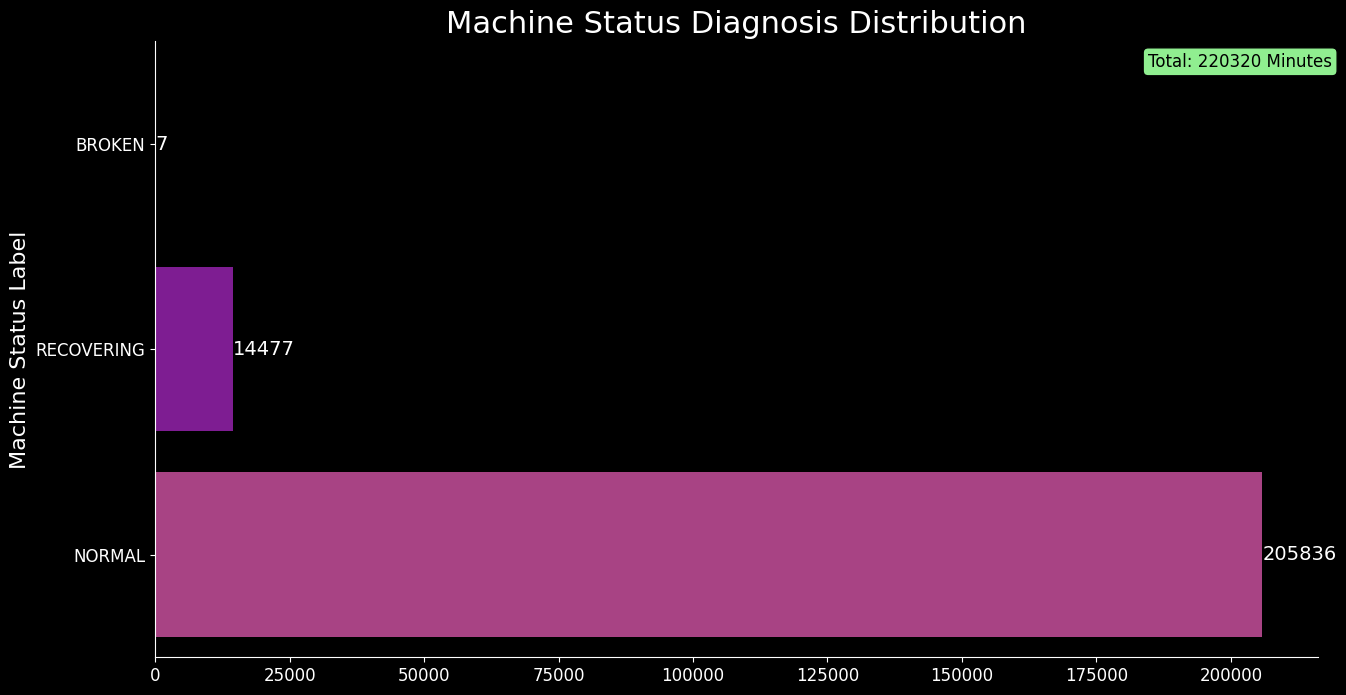

In [ ]:
# View Diagnosis Distribution
fig = plt.figure(figsize=(15, 8))
plt.title('Machine Status Diagnosis Distribution', fontsize=22);

status_distribution = data_df[CFG.TARGET].value_counts().sort_values()

bar_plot = sns.barplot(
    x=status_distribution.values,
    y=status_distribution.keys(),
    palette=sns.color_palette("plasma"),
    orient="h"
);

for container in bar_plot.containers:
    bar_plot.bar_label(container, fmt='%.0f', fontsize=14);

plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.ylabel('Machine Status Label', fontsize=16);

text_params = {
    'x'       : status_distribution.max() * 0.98,
    'y'       : -0.4,
    's'       : f"Total: {len(data_df)} Minutes",
    'size'    : 12,
    'color'   : "black",
    'ha'      : "center",
    'va'      : "center",
    'bbox'    : dict(boxstyle="round", fc=("lightgreen"),ec=("black"))
}
plt.text(**text_params);
plt.grid(False);
sns.despine();

### Generate Date related feature

In [ ]:
def process_date_features(
    df:pd.DataFrame,
    date_column:str,
    prefix:str='',
    generate_features:bool=False) -> pd.DataFrame:

    if not(generate_features):
        return df

    df_columns = df.columns

    # Generate Date Features
    df['year'] = df[date_column].dt.year.astype(np.int32)
    df['quarter'] = df[date_column].dt.quarter.astype(np.int32)

    df['month'] = df[date_column].dt.month.astype(np.int32)
    df['day'] = df[date_column].dt.day.astype(np.int32)
    df['hour'] = df[date_column].dt.hour.astype(np.int32)
    df['minute'] = df[date_column].dt.minute.astype(np.int32)

    df['day_of_year'] = df[date_column].dt.dayofyear.astype(np.int32)
    df['day_of_week'] = df[date_column].dt.dayofweek.astype(np.int32)

    df['week'] = df[date_column].dt.isocalendar().week.astype(np.int32)

    # Cyclic feature transforms
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4.0)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12.0)
    df['week_sin'] =  np.sin(2 * np.pi * df['month'] / 52.0)

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 30.0)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60.0)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7.0)

    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4.0)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12.0)
    df['week_cos'] =  np.cos(2 * np.pi * df['month'] / 52.0)

    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 30.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60.0)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7.0)

    if len(prefix) > 0:
        columns = [_ for _ in df.columns if _ not in df_columns]
        df = df.rename(columns={col: f'{prefix}_{col}' for col in columns})

    return df

In [ ]:
# Convert dates to datetime objects
data_df[date_column] = pd.to_datetime(data_df[date_column])

In [ ]:
%%time
# Generate time-related features
data_df = process_date_features(
    data_df,
    date_column=date_column,
    prefix='',
    generate_features=True
)

# Get time-related features list
time_features = non_time_features = [
    _ for _ in data_df.columns
    if _ not in [*sensors, *ignored_columns]
]

print(data_df[time_features].head(3).T.to_markdown())

|                 |              0 |              1 |              2 |
|:----------------|---------------:|---------------:|---------------:|
| year            | 2018           | 2018           | 2018           |
| quarter         |    2           |    2           |    2           |
| month           |    4           |    4           |    4           |
| day             |    1           |    1           |    1           |
| hour            |    0           |    0           |    0           |
| minute          |    0           |    1           |    2           |
| day_of_year     |   91           |   91           |   91           |
| day_of_week     |    6           |    6           |    6           |
| week            |   13           |   13           |   13           |
| quarter_sin     |    1.22465e-16 |    1.22465e-16 |    1.22465e-16 |
| month_sin       |    0.866025    |    0.866025    |    0.866025    |
| week_sin        |    0.464723    |    0.464723    |    0.464723    |
| day_

### Plot Sensor Time Series

  0%|          | 0/10 [00:00<?, ?it/s]

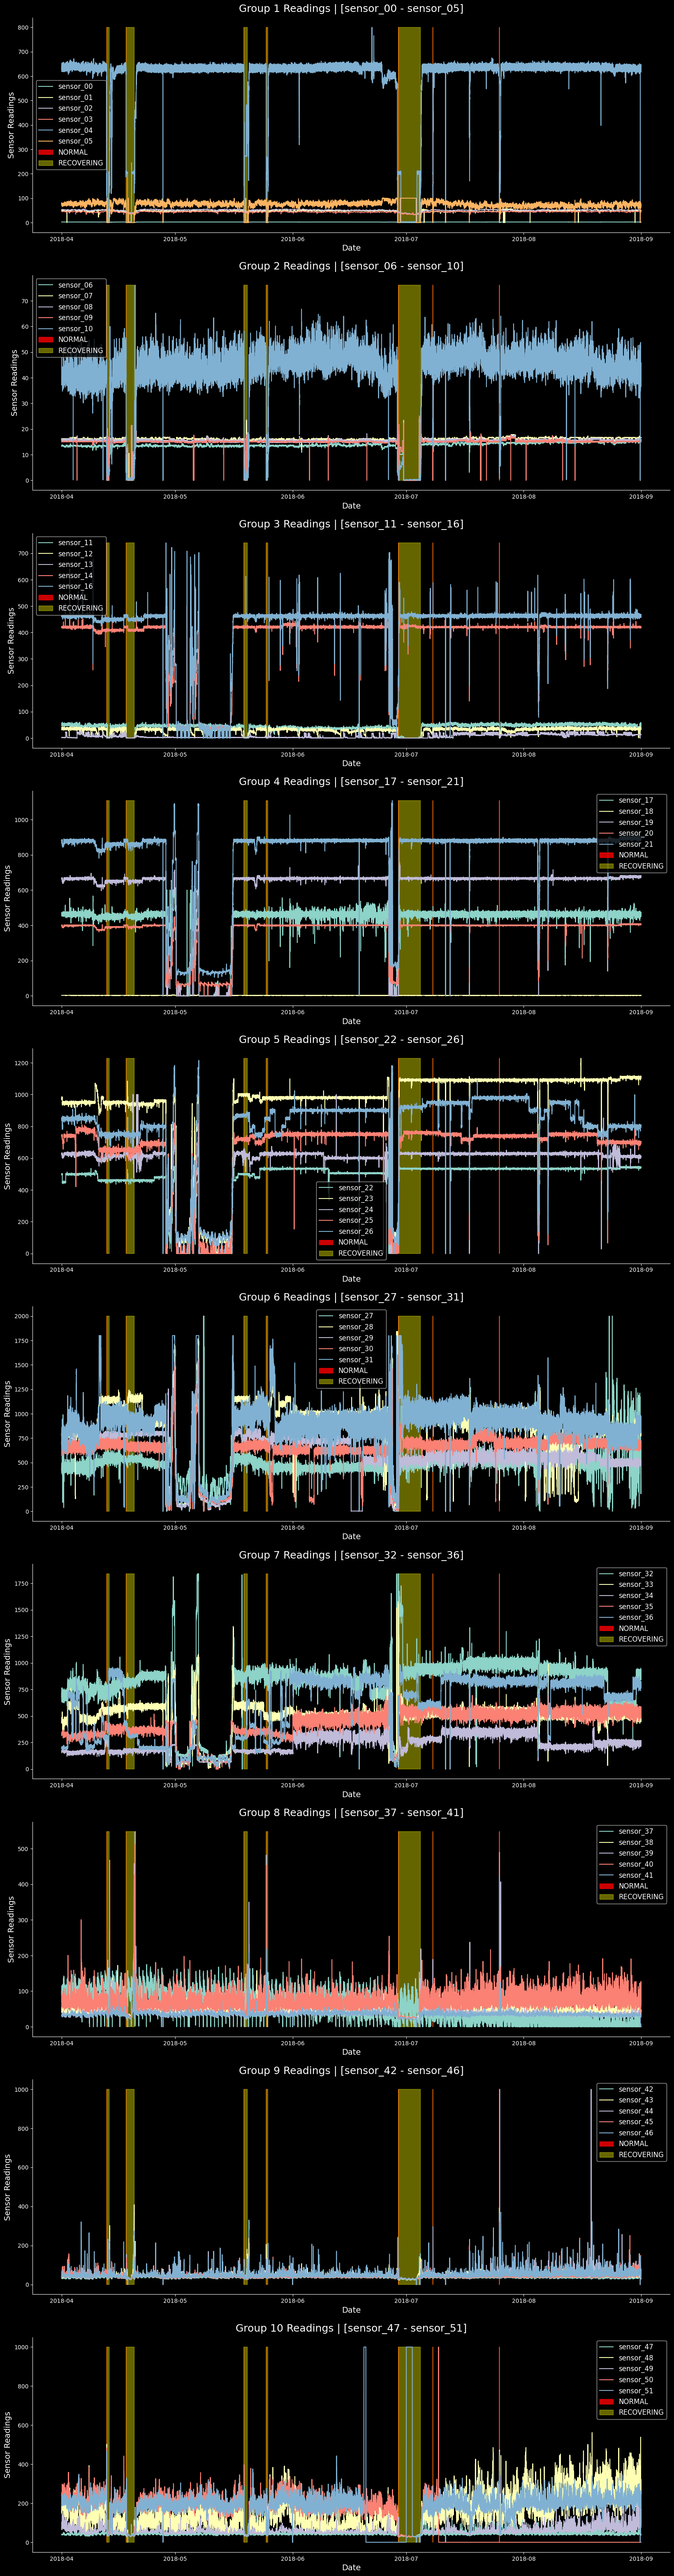

In [ ]:
# Define plot figure
fig = plt.figure(figsize=(20, 80))
fig.tight_layout(h_pad=8)

# Split sensors into groups
sensor_groups = np.array_split(sensors, 10)
n_groups = len(sensor_groups)

for group, sensor_group in enumerate(tqdm(sensor_groups)):
    # Initiate subplot
    plt.subplot(n_groups, 1, group + 1)

    # Get group sensory readings
    query = data_df[[date_column, *sensor_group, CFG.TARGET_ENCODED]]

    # Plot readings for each sensor
    for sensor in sensor_group:
        sns.lineplot(
            data=query,
            x=date_column,
            y=sensor,
            label=sensor
        );

    # Get group sensor max & min readings
    y_min = query[sensor_group].min().min()
    y_max = query[sensor_group].max().max()

    # Plot shaded area for BROKEN machine status
    plt.fill_between(
        query[date_column], y_min, y_max, where=(query[CFG.TARGET_ENCODED]==1),
        color='red', alpha=0.8, interpolate=True, label=id2label[0]
    );


    # Plot shaded area for RECOVERING machine status
    plt.fill_between(
        query[date_column], y_min, y_max, where=(query[CFG.TARGET_ENCODED]==2),
        color='yellow', alpha=0.4, interpolate=True, label=id2label[2]
    );

    # Finish subplot setup
    plt.xlabel('Date', fontsize=14);
    plt.ylabel('Sensor Readings', fontsize=14);
    plt.title(
        f'Group {group+1} Readings | [{sensor_group[0]} - {sensor_group[-1]}]',
        fontsize=18, pad=10
    );
    # Show Legend
    plt.legend(fontsize=12);
    plt.grid(False);

sns.despine();
plt.show();

### Assign System Failures To Group

In [ ]:
group_idx = 0
anomaly_group = [0]
target_series = data_df[CFG.TARGET].to_list()

# Generate groups for each anomaly case
for _ in range(1, len(data_df)):
    if (target_series[_] == 'NORMAL' and target_series[_ - 1] == 'RECOVERING'):
        group_idx += 1

    anomaly_group.append(group_idx)

# Add groups to dataset
data_df['anomaly_group'] = np.array(anomaly_group).astype(np.int32)
data_df['anomaly_group']

0         0
1         0
2         0
3         0
4         0
         ..
220315    7
220316    7
220317    7
220318    7
220319    7
Name: anomaly_group, Length: 220320, dtype: int32

In [ ]:
groups = list(set(data_df['anomaly_group']))
group_dict = {}

# Get system failure instance label counts
for _ in groups:
    group_dict[_] = dict(
        data_df[data_df['anomaly_group'] == _]
        [CFG.TARGET]
        .value_counts()
    )
# Create summary df for system failure counts
group_df = pd.DataFrame(group_dict).T.fillna(0).astype(np.int32)
group_df

NORMAL  RECOVERING  BROKEN
0   17155         944       1
1    6410        3110       1
2   41697        1312       1
3    7159         605       1
4   49644        8390       1
5    4700          41       1
6   25267          75       1
7   53804           0       0

# Data Preprocessing

In [ ]:
# Initialise lag feature variables
lag_features = []
n_lags = 4
feaures_added = False

In [ ]:
if not (feaures_added):
    for lag in range(n_lags):
        lag_sensors = {}

        for sensor in sensors:
            # Create lag feature name
            sensor_feature = sensor + f'_revealed_{lag + 1}'

            # Generate lag feature
            lag_sensor_reading = data_df[sensor].shift(lag + 1)

            # Add lag feature to dataset
            lag_sensors[sensor_feature] = lag_sensor_reading

            # Record lag feature name
            lag_features.append(sensor_feature)

        # Generate DataFrame from lag features & append to orignal dataset
        data_df = pd.concat([data_df, pd.DataFrame(lag_sensors)], axis=1)

    # Set flag to True to avoid adding duplications
    feaures_added = True
else:
    print('Features have already been added!')

In [ ]:
# Generate Train & Test splits based on assigned groups
train_df = data_df[
    ~data_df['anomaly_group'].isin([6, 7])
]

test_df = data_df[
    data_df['anomaly_group'].isin([6, 7])
].reset_index(drop=True)

# View train data
train_df.head(10)

timestamp  sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
0 2018-04-01 00:00:00   2.465394  47.092010    53.2118  46.310760  634.375000   
1 2018-04-01 00:01:00   2.465394  47.092010    53.2118  46.310760  634.375000   
2 2018-04-01 00:02:00   2.444734  47.352428    53.2118  46.397572  638.888916   
3 2018-04-01 00:03:00   2.460474  47.092010    53.1684  46.397568  628.125000   
4 2018-04-01 00:04:00   2.445718  47.135410    53.2118  46.397568  636.458313   
5 2018-04-01 00:05:00   2.453588  47.092010    53.1684  46.397568  637.615723   
6 2018-04-01 00:06:00   2.455556  47.048611    53.1684  46.397568  633.333313   
7 2018-04-01 00:07:00   2.449653  47.135410    53.1684  46.397568  630.671326   
8 2018-04-01 00:08:00   2.463426  47.092010    53.1684  46.397568  631.944397   
9 2018-04-01 00:09:00   2.445718  47.178822    53.1684  46.397568  641.782288   

   sensor_05  sensor_06  sensor_07  sensor_08  ...  sensor_42_revealed_4  \
0  76.459747   13.41146  16.131359   15.56713  ...                   NaN   
1  76.459747   13.41146  16.131359   15.56713  ...                   NaN   
2  73.545982   13.32465  16.037331   15.61777  ...                   NaN   
3  76.988983   13.31742  16.247110   15.69734  ...                   NaN   
4  76.588966   13.35359  16.210939   15.69734  ...             31.770832   
5  78.185677   13.41146  16.167530   15.89265  ...             31.770832   
6  75.816139   13.43316  16.131359   15.65393  ...             31.770830   
7  75.773308   13.25231  16.124130   16.19647  ...             31.510420   
8  74.589157   13.28848  16.131359   15.47309  ...             31.510420   
9  74.574280   13.38252  16.247110   15.61777  ...             31.250000   

   sensor_43_revealed_4  sensor_44_revealed_4  sensor_45_revealed_4  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4             41.927078             39.641201             65.682869   
5             41.927078             39.641201             65.682869   
6             41.666660             39.351852             65.393517   
7             40.885410             39.062500             64.814812   
8             41.406250             38.773151             65.104156   
9             42.708328             38.773151             63.657410   

   sensor_46_revealed_4  sensor_47_revealed_4  sensor_48_revealed_4  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4             50.925930             38.194439            157.986099   
5             50.925930             38.194439            157.986099   
6             51.215279             38.194443            155.960602   
7             51.215279             38.194439            155.960602   
8             51.793980             38.773151            158.275497   
9             51.793980             38.773151            164.641205   

   sensor_49_revealed_4  sensor_50_revealed_4  sensor_51_revealed_4  
0                   NaN                   NaN                   NaN  
1                   NaN                   NaN                   NaN  
2                   NaN                   NaN                   NaN  
3                   NaN                   NaN                   NaN  
4             67.708344            243.055603            201.388901  
5             67.708344            243.055603            201.388901  
6             67.129631            241.319397            203.703705  
7             66.840279            240.451401            203.125000  
8             66.550926            242.187500            201.388901  
9             66.55

In [ ]:
def plot_target(df, target_col=CFG.TARGET_ENCODED, set_name='Train'):
    # Define plot figure
    fig = plt.figure(figsize=(20, 6))

    # Get group sensor max & min readings
    y_min = 0
    y_max = 1

    # Plot shaded area for NORMAL machine status
    plt.fill_between(
        df[date_column], y_min, y_max, where=(df[target_col]==0),
        color='lightgreen', alpha=0.3, interpolate=True, label=id2label[0]
    );

    # Plot shaded area for BROKEN machine status
    plt.fill_between(
        df[date_column], y_min, y_max, where=(df[target_col]==1),
        color='red', alpha=0.9, interpolate=True, label=id2label[1]
    );

    # Plot shaded area for RECOVERING machine status
    plt.fill_between(
        df[date_column], y_min, y_max, where=(df[target_col]==2),
        color='yellow', alpha=0.3, interpolate=True, label=id2label[2]
    );

    # Finish subplot setup
    plt.xlabel('Date', fontsize=14);
    plt.ylabel('', fontsize=12);
    plt.title(
        f'{set_name} Machine Status Time Plot',
        fontsize=18, pad=20
    );

    # Show Legend
    plt.legend(fontsize=14);
    plt.grid(False);

    sns.despine();
    plt.show();

    return

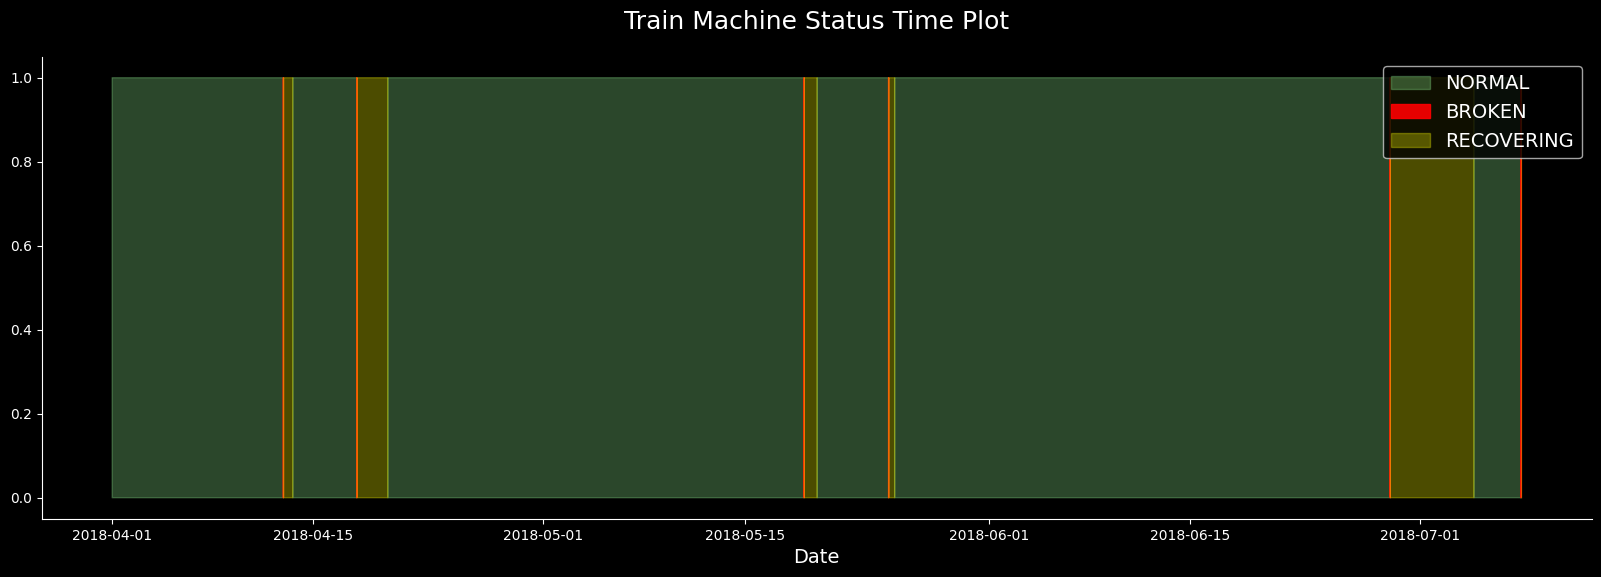

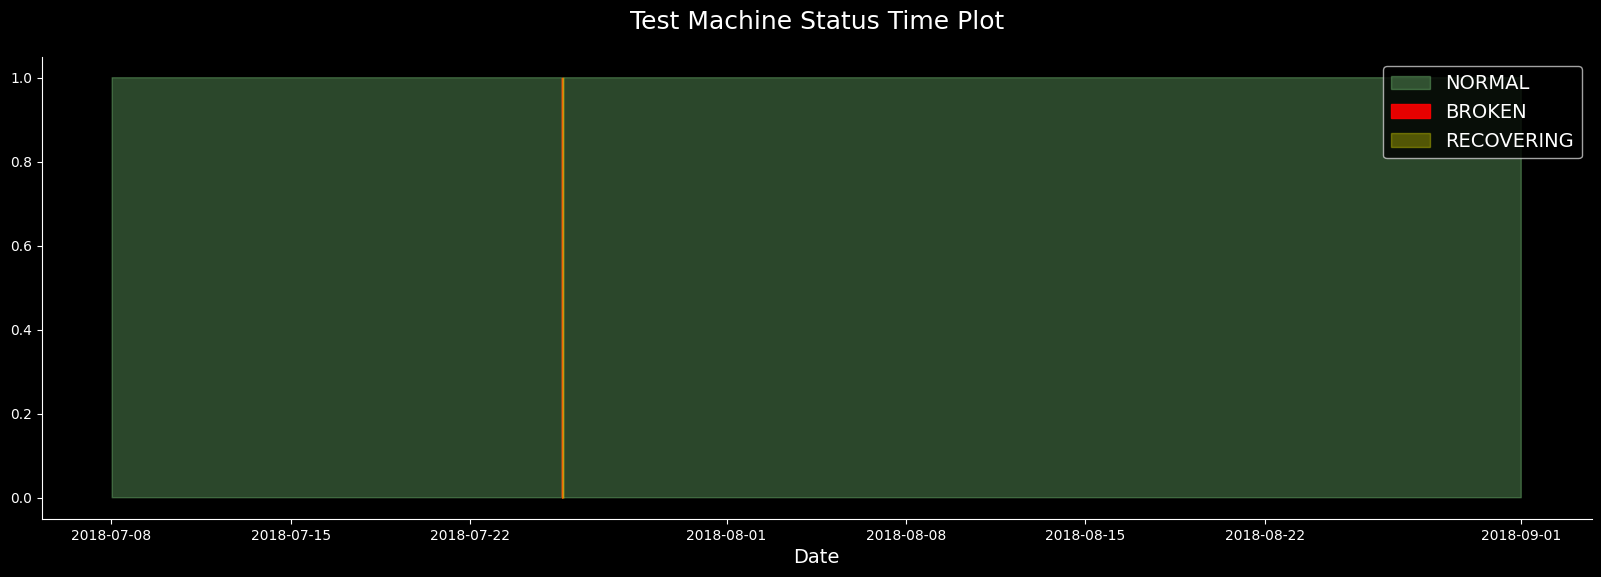

In [ ]:
# Plot train machine status time plot
plot_target(train_df, target_col=CFG.TARGET_ENCODED, set_name='Train')

# Plot test machine status time plot
plot_target(test_df, target_col=CFG.TARGET_ENCODED, set_name='Test')

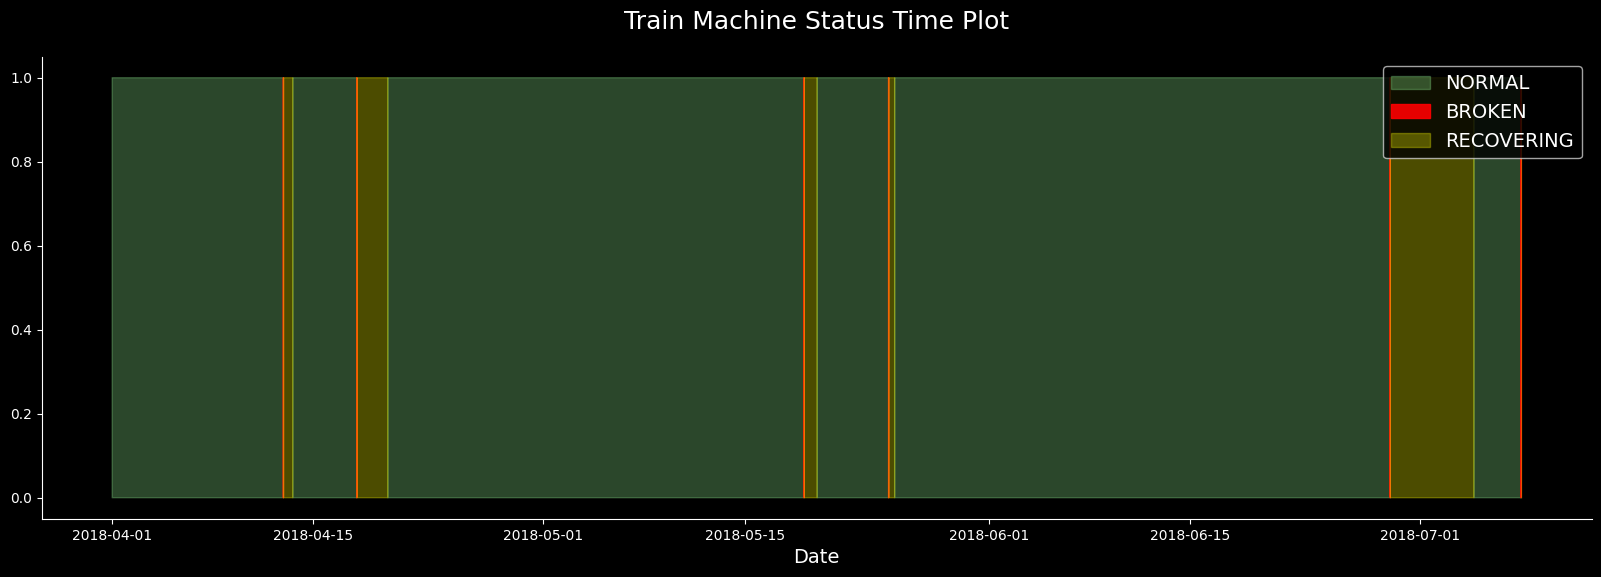

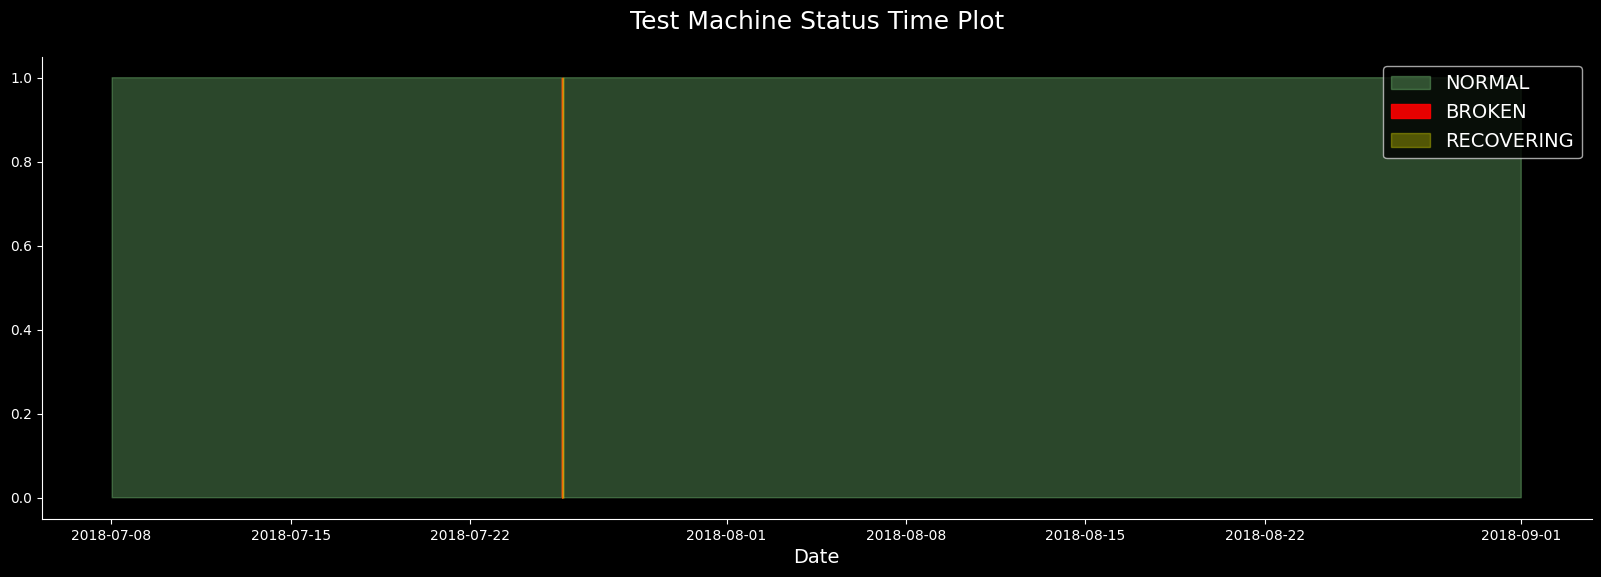

In [ ]:
# Plot train machine status time plot
plot_target(train_df, target_col=CFG.TARGET_ENCODED, set_name='Train')

# Plot test machine status time plot
plot_target(test_df, target_col=CFG.TARGET_ENCODED, set_name='Test')

# Train Cross-Validation Models

In [ ]:
# Define input features for training
selected_features = [
    *time_features,
    *sensors,
    *lag_features
]

In [ ]:
def generate_model(xgb_params, lgbm_params):
        xgb_model = xgb.XGBClassifier(**xgb_params)
        lgbm_model = lgb.LGBMClassifier(**lgbm_params)

        ensemble_models = [
            ('XGB', xgb_model),
            ('LGBM', lgbm_model),
        ]

        return ensemble_models

def generate_voting_classifier(models):
    voting_params = {
        'estimators' : models,
        'n_jobs'     : CFG.NUM_WORKERS,
        'weights'    : [0.5, 0.5],
        'voting'     : 'soft',
    }

    return VotingClassifier(**voting_params)

In [ ]:
def fit_cv(
    model_constructor, model_params,
    cv_folds, data_ds,
    features, target, metric_fn,
    metric_name='f1_score',
    model_name='XGBoost'):

    # Create session dict
    session = {
        'scores'         : [],
        'predictions'    : [],
        'models'         : [],
        'name'           : model_name
    }

    feature_data = data_ds[features]
    target_data = data_ds[target]
    groups = data_ds['anomaly_group']
    pbar = tqdm(total=CFG.NUM_FOLDS)

    # Train models on folds
    print(f'Training {model_name} Models')
    for fold, (train_idx, val_idx) in enumerate(
        cv_folds.split(feature_data, target_data, groups=groups)):

        print('----------------------------------')
        print(f"Training on Fold {fold + 1} ... \n")

        # Get Fold Training and Validation Split Data
        X_train, X_val = feature_data.iloc[train_idx], feature_data.iloc[val_idx]
        y_train, y_val = target_data[train_idx], target_data[val_idx]

        # Generate model
        if model_name == 'Voting':
            voting_models = generate_model(
                model_params['xgb_params'],
                model_params['lgbm_params']
            )
            model = model_constructor(voting_models)
        else:
            model = model_constructor(**model_params)

        # Fit the model
        fit_params = {
            'X': X_train,
            'y': y_train.to_numpy(),
        }

        if model_name == 'XGBoost':
            fit_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]
            fit_params['early_stopping_rounds'] = 100
            fit_params['verbose'] = 0

        if model_name == 'LightGBM':
            fit_params['eval_set'] = (X_val, y_val)
            fit_params['callbacks'] = [
                lgb.early_stopping(stopping_rounds=100, verbose=0),
            ]

        if model_name == 'CatBoost':
            fit_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]
            fit_params['early_stopping_rounds'] = 100
            fit_params['verbose'] = 0

        start = time.perf_counter()
        model.fit(**fit_params)
        end = time.perf_counter()

        # Compute total training time
        total_training_time = end - start

        # Generate & Record Metric
        val_predictions = model.predict(X_val.to_numpy())
        val_score = metric_fn(y_val, val_predictions)
        session['scores'].append(val_score)

        # Print Training Time & Metric
        print(f'Time: {total_training_time:.2f}s\t| {metric_name}: {val_score:.4f}')

        # Record Model
        session['models'].append(model)

        pbar.update()

    # Print OOF Metric score
    print('==================================')
    print(f"\nOOF {metric_name}:\t\t{np.mean(session['scores']):.4f}")
    print('==================================')

    return session

In [ ]:
# Define XGBoost classifier parameters
xgb_params = {
    'n_estimators'          : 544,
    'max_depth'             : 9,
    'learning_rate'         : 0.18941833094158878,
    'reg_lambda'            : 0.9223419888230734,
    'reg_alpha'             : 1.0156947388572535,
    'gamma'                 : 0.6923174218736504,
    'random_state'          : CFG.SEED,
    'objective'             : 'multi:softmax',
    'eval_metric'           : 'mlogloss',
    'tree_method'           : 'hist',
    'device'                : 'cuda'
}

# Define LGBM classifier parameters
lgbm_params = {
    'n_estimators'          : 421,
    'max_depth'             : 7,
    'learning_rate'         : 0.7355983623945621,
    'reg_lambda'            : 0.5960348038227966,
    'min_data_in_leaf'      : 75,
    'is_unbalance'          : 'true',
    'objective'             : 'multiclass',
    'metric'                : 'multi_logloss',
    'random_state'          : CFG.SEED,
    'num_classes'           : 3,
    'verbosity'             : -1
}

params = {
    'xgb_params'  : xgb_params,
    'lgbm_params' : lgbm_params,
}

# Define CV generator
cv_generator = StratifiedGroupKFold(n_splits=CFG.NUM_FOLDS)

In [ ]:
%%time

def fn_metric(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

# Define session parameters
session_params = {
    'model_constructor'    : generate_voting_classifier,
    'model_params'         : params,
    'cv_folds'             : cv_generator,
    'data_ds'              : train_df,
    'features'             : selected_features,
    'target'               : CFG.TARGET_ENCODED,
    'metric_fn'            : fn_metric,
    'metric_name'          : 'f1_score',
    'model_name'           : 'Voting'
}

# Execute training session
session = fit_cv(**session_params)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Voting Models
----------------------------------
Training on Fold 1 ... 



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [07:45:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Time: 100.86s	| f1_score: 0.6077
----------------------------------
Training on Fold 2 ... 

Time: 114.47s	| f1_score: 0.5164
----------------------------------
Training on Fold 3 ... 

Time: 136.43s	| f1_score: 0.6616
----------------------------------
Training on Fold 4 ... 

Time: 151.62s	| f1_score: 0.5656
----------------------------------
Training on Fold 5 ... 

Time: 150.02s	| f1_score: 0.5855

OOF f1_score:		0.5873
CPU times: user 15.1 s, sys: 2.21 s, total: 17.3 s
Wall time: 11min 4s


In [ ]:
def ensemble_predict(session_models, features_df):
    predictions = []

    for model in tqdm(session_models):
        model_preds = model.predict(features_df)
        predictions.append(model_preds)

    return predictions

In [ ]:
%%time
ensemble_preds = ensemble_predict(
    session['models'],
    test_df[selected_features]
)

# Ensemble predictions via median
test_preds = np.median(ensemble_preds, axis=0)
test_preds

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 27.3 s, sys: 1.12 s, total: 28.5 s
Wall time: 31.4 s


array([2., 2., 2., ..., 0., 0., 0.])

In [ ]:
%%time
train_ensemble_preds = ensemble_predict(
    session['models'],
    train_df[selected_features]
)

# Ensemble predictions via median
train_preds = np.median(train_ensemble_preds, axis=0)
train_preds

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 54.2 s, sys: 1.98 s, total: 56.2 s
Wall time: 1min 10s


array([0., 0., 0., ..., 2., 2., 2.])

# Analyse model performance

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)

    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20)
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0)

    # Plot confusion matrix
    plt.show()

    return

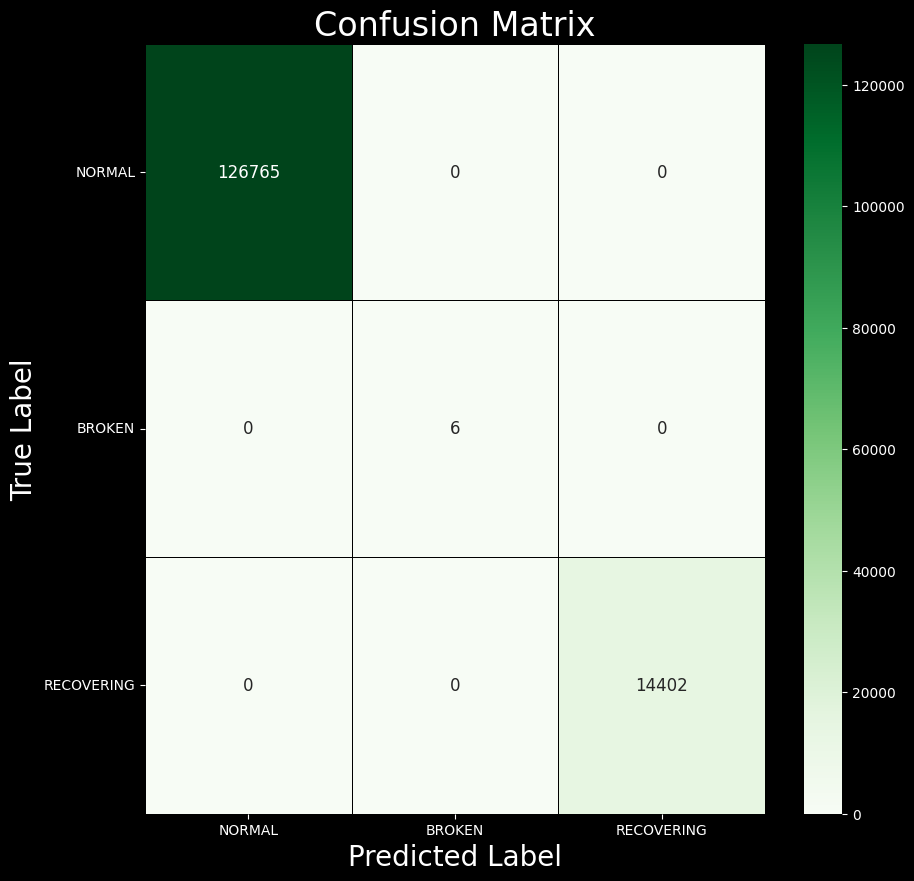

In [ ]:
plot_confusion_matrix(
    train_df[CFG.TARGET_ENCODED],
    train_preds,
    figsize=(10, 10),
    classes=all_labels
)

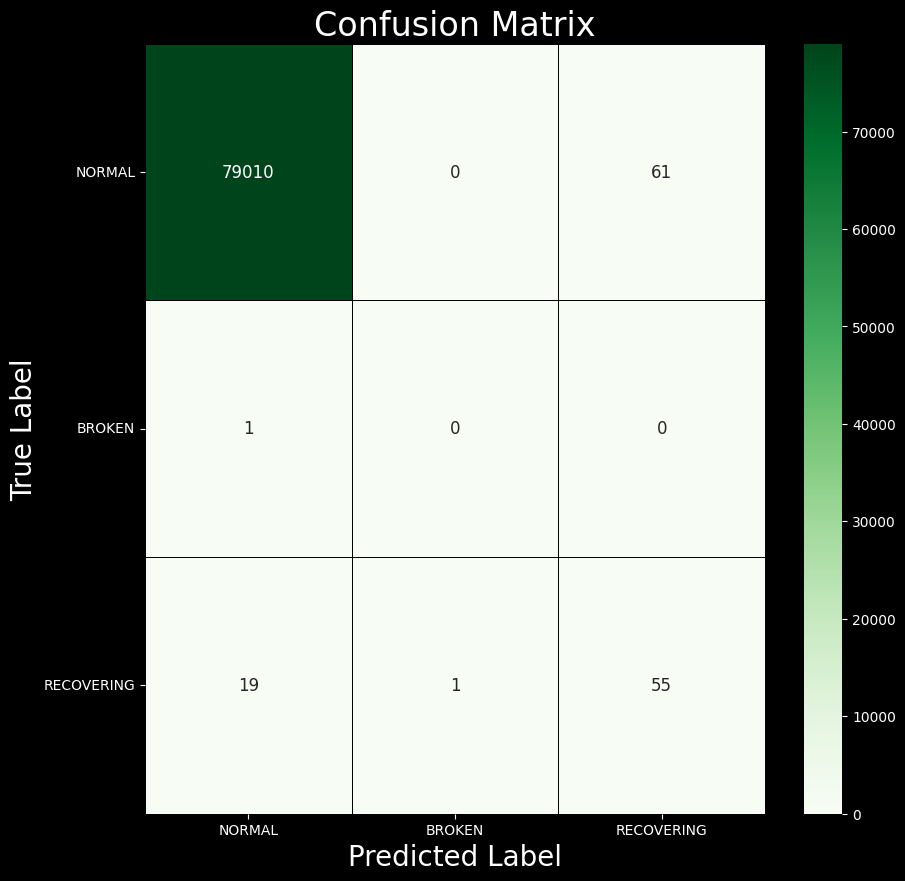

In [ ]:
plot_confusion_matrix(
    test_df[CFG.TARGET_ENCODED],
    test_preds,
    figsize=(10, 10),
    classes=all_labels
)

### Classification Report

In [ ]:
print(
    classification_report(
        test_df[CFG.TARGET_ENCODED],
        test_preds,
        target_names=all_labels
))

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     79071
      BROKEN       0.00      0.00      0.00         1
  RECOVERING       0.47      0.73      0.58        75

    accuracy                           1.00     79147
   macro avg       0.49      0.58      0.53     79147
weighted avg       1.00      1.00      1.00     79147



In [ ]:
def generate_performance_scores(y_true, y_pred):

    model_accuracy = accuracy_score(y_true, y_pred)

    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="macro"
        )
    )
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)

    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')

    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [ ]:
performance_metrics = generate_performance_scores(
    test_df[CFG.TARGET_ENCODED], test_preds
)


Performance Metrics:

accuracy_score:		0.9990

_____________________________________________
precision_score:	0.4913

_____________________________________________
recall_score:		0.5775

_____________________________________________
f1_score:		0.5251

_____________________________________________
matthews_corrcoef:	0.5881



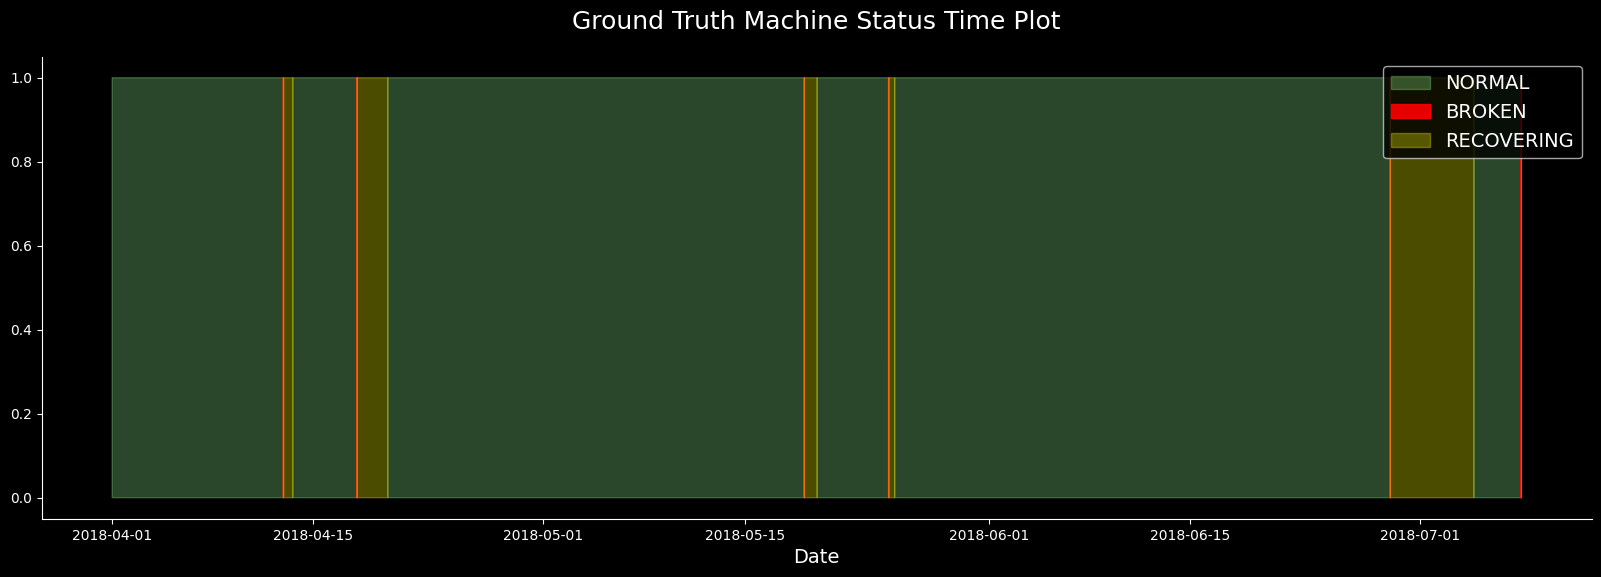

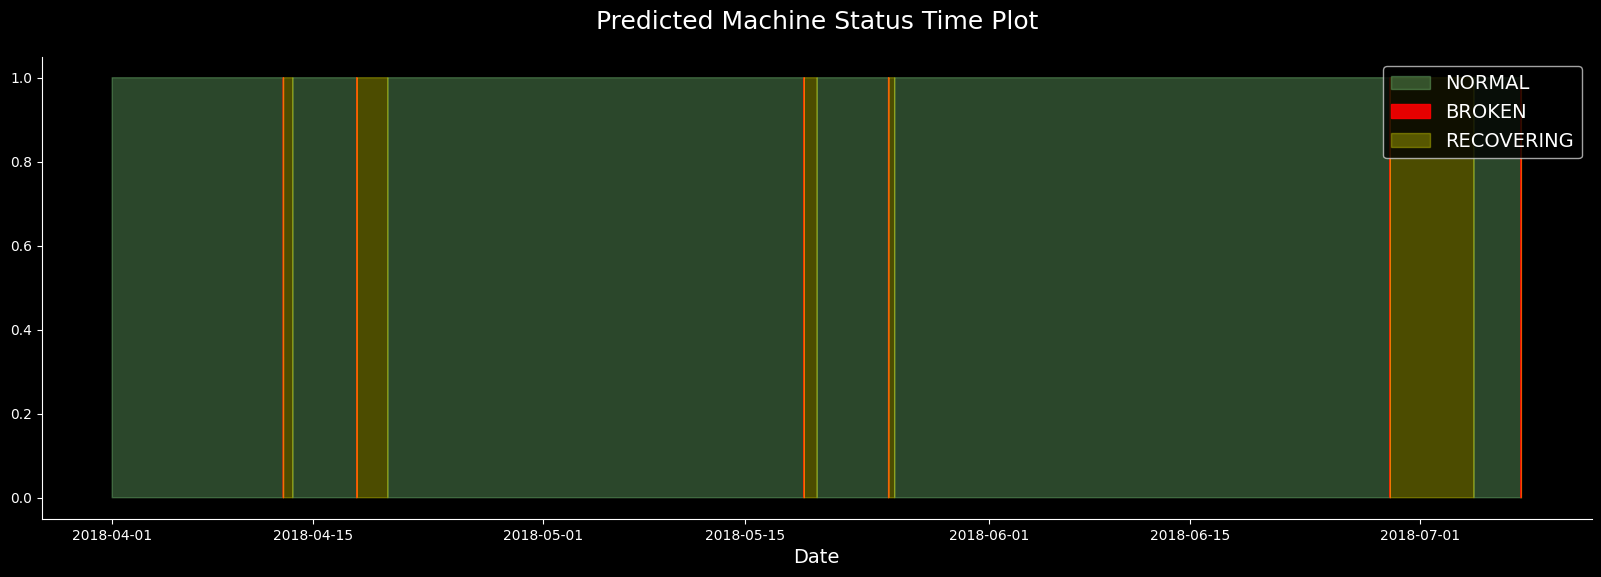

In [ ]:
train_pred_df = train_df[[date_column]].copy()
train_pred_df['preds'] = np.array(train_preds)

# Plot actual and predicted status time plot
plot_target(train_df, target_col=CFG.TARGET_ENCODED, set_name='Ground Truth')
plot_target(train_pred_df, target_col='preds', set_name='Predicted')

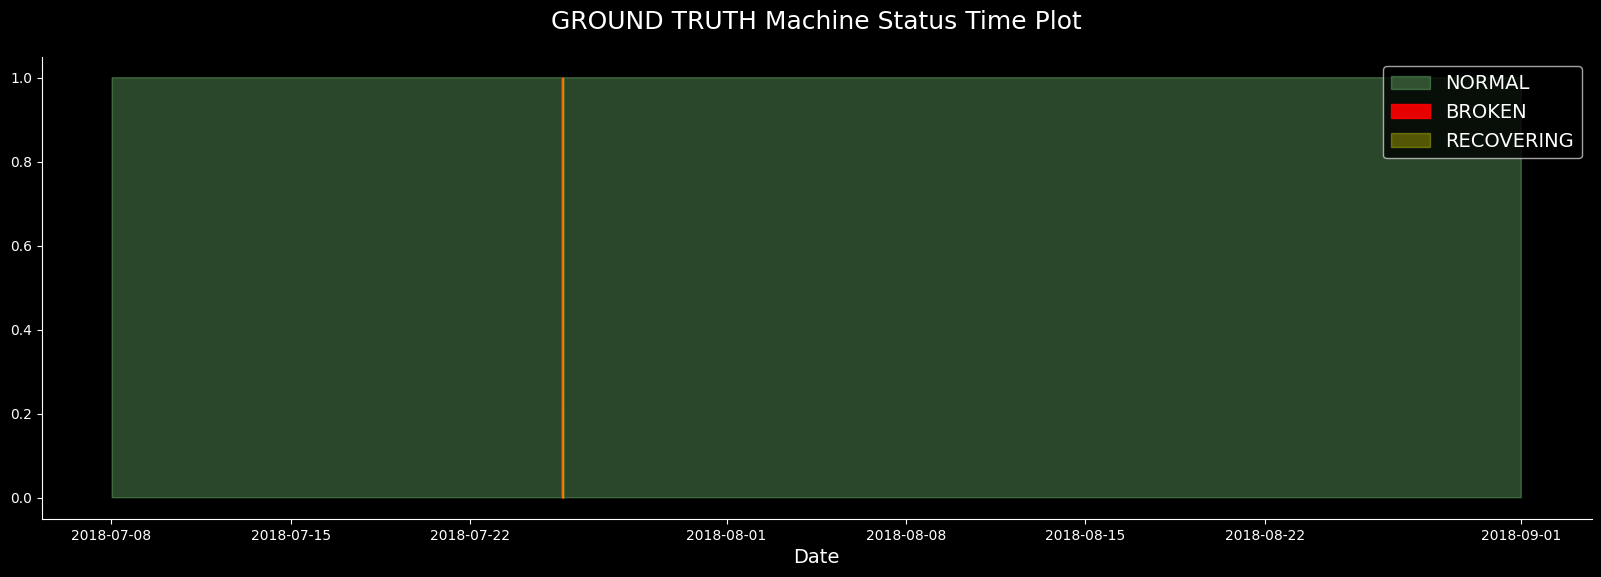

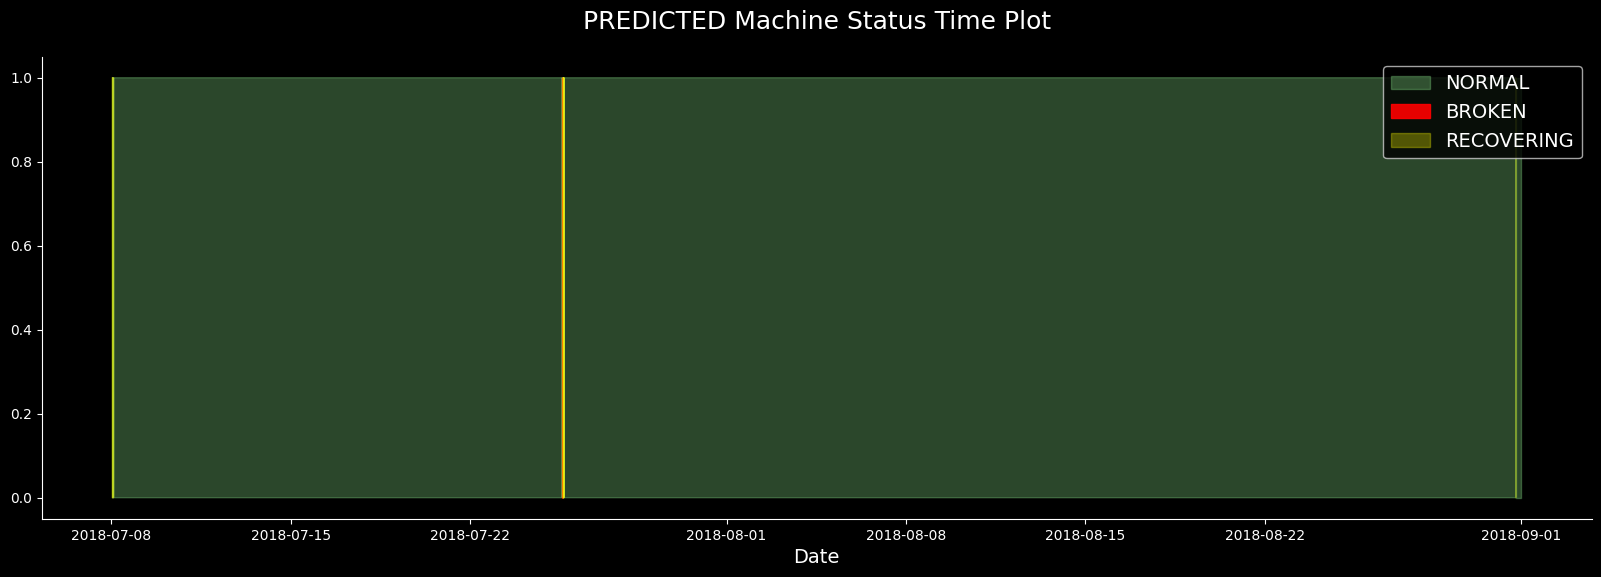

In [ ]:
test_df['preds'] = np.array(test_preds)

# Plot actual and predicted status time plot
plot_target(test_df, target_col=CFG.TARGET_ENCODED, set_name='GROUND TRUTH')
plot_target(test_df, target_col='preds', set_name='PREDICTED')

In [ ]:
def get_breakdown_end(df, start_idx):
    breakdown_df = df.iloc[start_idx:, :]
    end_idx = 0
    for _ in range(len(breakdown_df)):
        if breakdown_df[CFG.TARGET][start_idx+_] == 'NORMAL':
            end_idx = start_idx+_
            break

    return end_idx

In [ ]:
broken_start = test_df[test_df[CFG.TARGET] == 'BROKEN'].index
broken_end = get_breakdown_end(test_df, broken_start[0])

bdf = test_df.iloc[broken_start[0]-10:broken_end, :]
bdf

timestamp  sensor_00  sensor_01  sensor_02  sensor_03  \
25257 2018-07-25 13:50:00   2.385706  45.833332  52.994789  44.053822   
25258 2018-07-25 13:51:00   2.384722  45.833332  53.038189  44.053818   
25259 2018-07-25 13:52:00   2.391609  45.833332  53.038193  44.053822   
25260 2018-07-25 13:53:00   2.384722  45.833328  53.038193  44.010410   
25261 2018-07-25 13:54:00   2.315856  45.789928  53.038189  44.010414   
...                   ...        ...        ...        ...        ...   
25338 2018-07-25 15:11:00   0.310880  46.484379  51.171871  46.527775   
25339 2018-07-25 15:12:00   0.304977  46.397572  51.085072  46.527771   
25340 2018-07-25 15:13:00   0.303993  46.310760  51.085072  46.484379   
25341 2018-07-25 15:14:00   0.301042  46.180550  51.041664  46.484379   
25342 2018-07-25 15:15:00   0.301042  46.093750  50.998260  46.440971   

        sensor_04  sensor_05  sensor_06  sensor_07  sensor_08  ...  \
25257  579.513855  71.988373   14.32292  16.167530  15.697340  ...   
25258  580.324097  69.997879   14.32292  16.203699  15.530960  ...   
25259  586.458313  70.107521   14.36632  16.124130  15.617770  ...   
25260  575.347168  69.954948   14.33015  16.124130  15.697340  ...   
25261   91.093750  72.344223   14.43866  16.124130  15.617770  ...   
...           ...        ...        ...        ...        ...  ...   
25338  152.526031  60.779308   15.08970  17.628759  18.200230  ...   
25339  152.178802  61.245449   15.08970  17.621531  18.243629  ...   
25340  151.021393  52.948170   15.12587  17.621531  18.236401  ...   
25341  152.988983  53.201420   15.08970  17.664930  18.301500  ...   
25342  151.252899  56.645432   15.11863  17.679399  18.127890  ...   

       sensor_43_revealed_4  sensor_44_revealed_4  sensor_45_revealed_4  \
25257             49.739578             65.393517             64.814812   
25258             49.218750             63.657410             63.368050   
25259             48.697910             61.342590             61.053242   
25260             48.697910             59.895828             60.474541   
25261             49.218750             58.159721             59.027779   
...                     ...                   ...                   ...   
25338             66.406250             95.196762             98.090279   
25339             64.062500             89.988426             91.145844   
25340             62.500000             85.069443             84.490738   
25341             60.416660             81.018517             78.703697   
25342             59.895828             77.835648             73.784721   

       sensor_46_revealed_4  sensor_47_revealed_4  sensor_48_revealed_4  \
25257             61.921299             52.372681            203.993103   
25258             61.342590             51.215279            217.592606   
25259             60.763889             49.768520            223.958298   
25260             60.763889             48.900459            230.034698   
25261             61.342590             47.743061            233.506897   
...                     ...                   ...                   ...   
25338             69.155090             62.789349            383.969910   
25339             66.840279             60.763889            359.085602   
25340             63.657410             59.895828            335.937500   
25341             60.474541             58.449070            315.104187   
25342             58.449070             58.159721            295.428314   

       sensor_49_revealed_4  sensor_50_revealed_4  sensor_51_revealed_4  preds  
25257             56.423611                   0.0            188.657394    0.0  
25258             57.870369                   0.0            185.763901    0.0  
25259             61.921299                   0.0            182.580994    0.0  
25260             63.657410                   0.0            179.976898    0.0  
25261             63.657410                   0.0            177.951401    0.0  
...       

  0%|          | 0/10 [00:00<?, ?it/s]

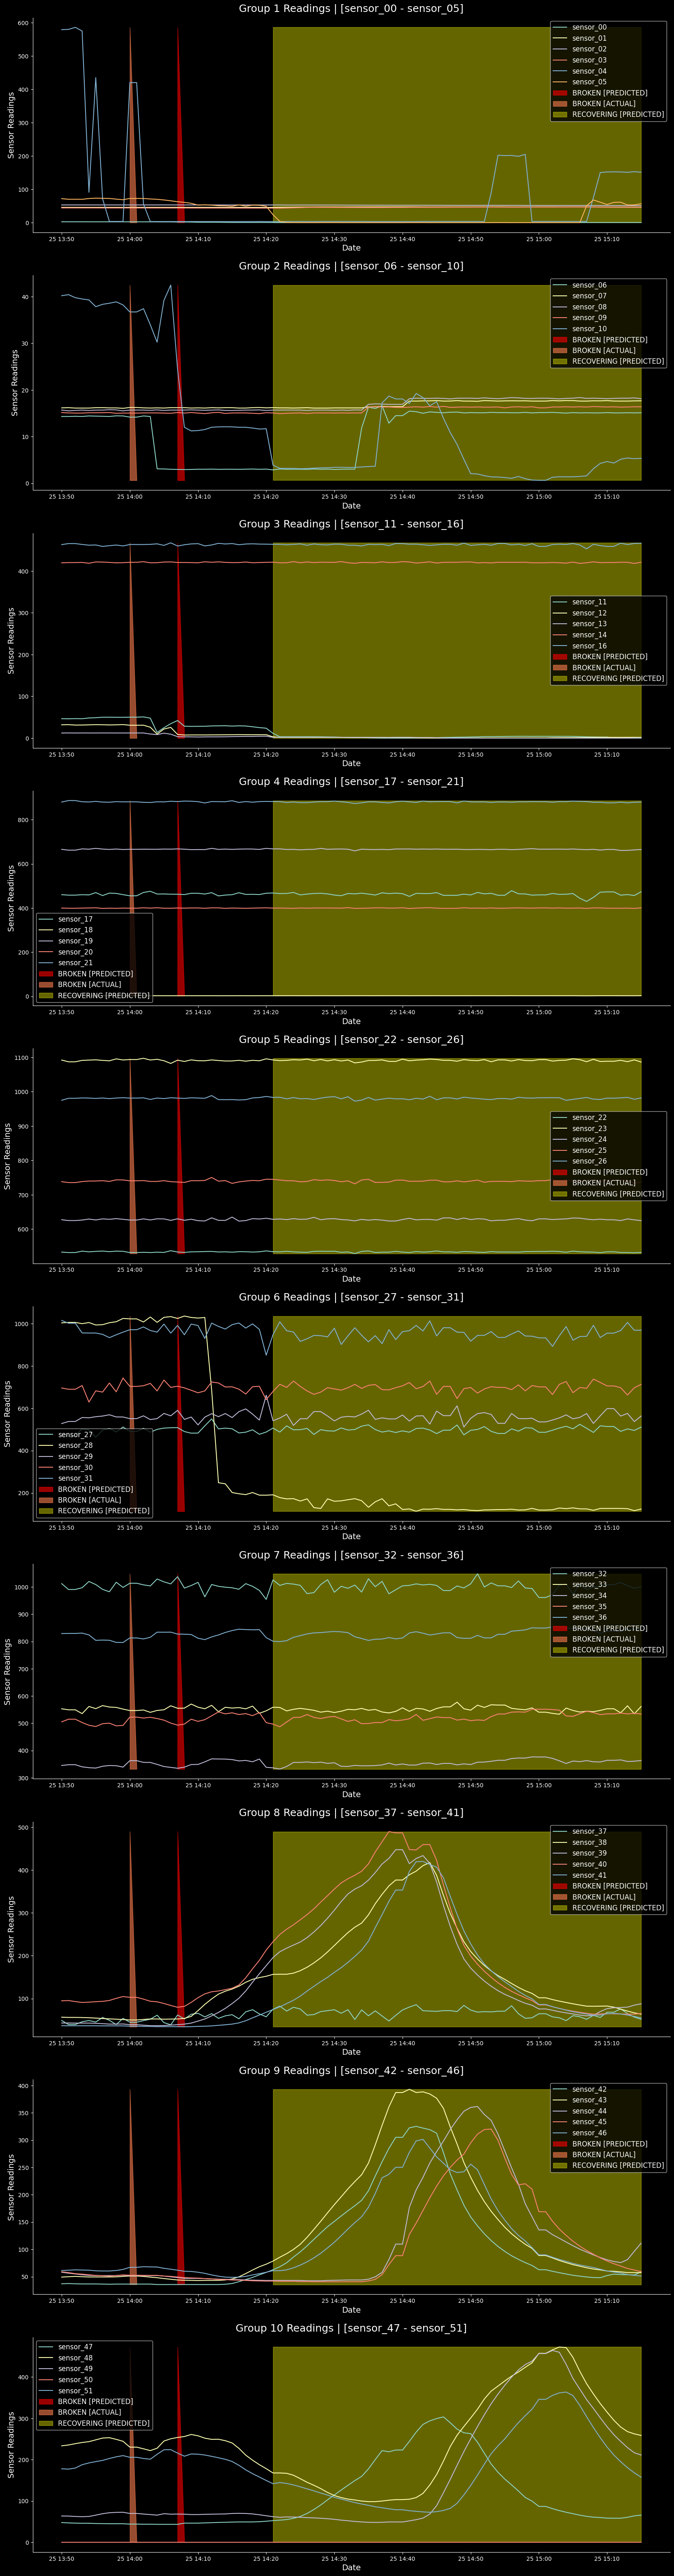

In [ ]:
# Define plot figure
fig = plt.figure(figsize=(20, 80))
fig.tight_layout(h_pad=8)

# Split sensors into groups
sensor_groups = np.array_split(sensors, 10)
n_groups = len(sensor_groups)

for group, sensor_group in enumerate(tqdm(sensor_groups)):
    # Initiate subplot
    plt.subplot(n_groups, 1, group + 1)

    # Get group sensory readings
    query = bdf[[date_column, *sensor_group, CFG.TARGET_ENCODED, 'preds']]

    # Plot readings for each sensor
    for sensor in sensor_group:
        sns.lineplot(
            data=query,
            x=date_column,
            y=sensor,
            label=sensor
        );

    # Get group sensor max & min readings
    y_min = query[sensor_group].min().min()
    y_max = query[sensor_group].max().max()

    # Plot shaded area for predicted BROKEN machine status
    plt.fill_between(
        query[date_column], y_min, y_max, where=(query['preds']==1),
        color='red', alpha=0.6, interpolate=True, label=id2label[1] + ' [PREDICTED]'
    );

    # Plot shaded area for actual BROKEN machine status
    plt.fill_between(
        query[date_column], y_min, y_max, where=(query[CFG.TARGET_ENCODED]==1),
        color='coral', alpha=0.6, interpolate=True, label=id2label[1] + ' [ACTUAL]'
    );


    # Plot shaded area for RECOVERING machine status
    plt.fill_between(
        query[date_column], y_min, y_max, where=(query['preds']==2),
        color='yellow', alpha=0.4, interpolate=True, label=id2label[2] + ' [PREDICTED]'
    );

    # Finish subplot setup
    plt.xlabel('Date', fontsize=14);
    plt.ylabel('Sensor Readings', fontsize=14);
    plt.title(
        f'Group {group+1} Readings | [{sensor_group[0]} - {sensor_group[-1]}]',
        fontsize=18, pad=10
    );
    # Show Legend
    plt.legend(fontsize=12);
    plt.grid(False);

sns.despine();
plt.show();